In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
import sys
import os
print(os.listdir("../input"))

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from keras.utils import np_utils
from keras.models import Model, load_model
from keras.layers import Input, concatenate, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K 
import tensorflow as tf
from keras.layers.core import Lambda, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Any results you write to the current directory are saved as output.

['train', 'test']


**Visualizing the training images**

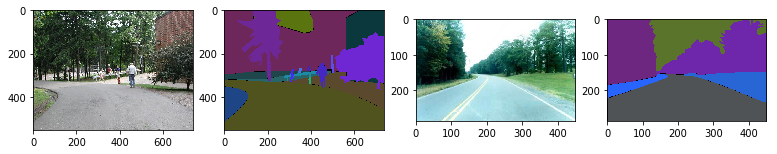

In [17]:
path_train='../input/train/train/'
ids= ['ADE_train_00001004','ADE_train_00001006']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(path_train+'images/' + img_name + '.jpg')
    img_mask = load_img(path_train+'masks/' + img_name+'_seg.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

**Finding train ids to use that id for the images and its mask simultaneously while training**

In [18]:
import re
train_ids = next(os.walk(path_train+"images"))[2]
print(len(train_ids))
new_train_ids=[]
for item in train_ids:
    new_train_ids.append(' '.join(re.findall(r'\d+', item)))
print(new_train_ids)

20
['00001020', '00001012', '00001016', '00001019', '00001014', '00001006', '00001008', '00001005', '00001013', '00001022', '00001007', '00001011', '00001009', '00001023', '00001021', '00001010', '00001015', '00001017', '00001004', '00001018']


**Attributes of training images and its Mask images**
Here n_labels=6 denotes that there are 6 classes in mask images

In [19]:
input_shape=(256, 256, 3)
im_width = input_shape[0]
im_height = input_shape[1]
im_chan = input_shape[2]
n_labels = 6

**Getting and resizing training images and masks **

In [20]:
X_train = np.zeros((len(new_train_ids), im_height, im_width, 3), dtype=np.uint8)
Y_train = np.zeros((len(new_train_ids), im_height, im_width, 1), dtype=np.bool)
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(new_train_ids), total=len(new_train_ids)):
    path = path_train
    img = load_img(path + 'images/ADE_train_' + id_+'.jpg')
    x = img_to_array(img)[:,:,1]
    x = resize(x, (256, 256, 3), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + 'masks/ADE_train_' + id_+'_seg.png'))[:,:,1]
    Y_train[n] = resize(mask, (256, 256,1), mode='constant', preserve_range=True)
print(Y_train.shape)
Y_train = np_utils.to_categorical(Y_train,n_labels)
print(X_train.shape)
print(Y_train.shape)
print('Done!')

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



(20, 256, 256, 1)
(20, 256, 256, 3)
(20, 256, 256, 6)
Done!


In [21]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


In [22]:
from keras.layers.normalization import BatchNormalization
input_shape=(256, 256, 3)
n_labels=6
kernel=3
# Build U-Net model
inputs = Input((input_shape))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(n_labels, (1, 1), activation='softmax') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[mean_iou])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 256, 256, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 8)  224         lambda_4[0][0]                   
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 256, 256, 8)  584         conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [23]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-segmentation.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 18 samples, validate on 2 samples
Epoch 1/30
18/18 [==============================] - 4s 217ms/step - loss: 1.8229 - mean_iou: 0.2315 - val_loss: 1.7590 - val_mean_iou: 0.4167

Epoch 00001: val_loss improved from inf to 1.75904, saving model to model-segmentation.h5
Epoch 2/30
18/18 [==============================] - 1s 39ms/step - loss: 1.7395 - mean_iou: 0.4167 - val_loss: 1.6508 - val_mean_iou: 0.4167

Epoch 00002: val_loss improved from 1.75904 to 1.65075, saving model to model-segmentation.h5
Epoch 3/30
18/18 [==============================] - 1s 35ms/step - loss: 1.6222 - mean_iou: 0.4167 - val_loss: 1.4908 - val_mean_iou: 0.4166

Epoch 00003: val_loss improved from 1.65075 to 1.49082, saving model to model-segmentation.h5
Epoch 4/30
18/18 [==============================] - 1s 34ms/step - loss: 1.4374 - mean_iou: 0.4164 - val_loss: 1.2052 - val_mean_iou: 0.4160

Epoch 00004: val_loss improved from 1.49082 to 1.20519, saving model to model-segmentation.h5
Epoch 5/30
18/18